
# 🧪 피부질환 분류 — 다중 분류 모델(P, I 버전)
증상이 비슷한 클래스별 **다중 분류** 로 재설계한 노트북입니다.  


In [1]:
%pip uninstall -y pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy, sklearn
print("numpy:", numpy.__version__)
print("sklearn:", sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
print("imports ok")


numpy: 2.1.3
sklearn: 1.6.1
imports ok


In [3]:
# ===== 전역 테마 & 한글 폰트 설정 =====
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import os

# 밝은(화이트) 배경 유지 + 파란계열 포커스
plt.style.use('default')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['savefig.facecolor'] = 'white'

# 🔤 한글 폰트 설정 (경로를 환경에 맞게 수정하세요)
font_path = 'NanumGothic.ttf'  # 예: '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
if os.path.exists(font_path):
    fontprop = fm.FontProperties(fname=font_path)
    rcParams['font.family'] = fontprop.get_name()
else:
    print(f"⚠️ 폰트 파일을 찾을 수 없습니다: {font_path}  (영문 폰트로 대체)")

# 마이너스 기호 깨짐 방지
rcParams['axes.unicode_minus'] = False

print("✅ 전역 테마 & 한글 폰트 설정 완료")


✅ 전역 테마 & 한글 폰트 설정 완료


✅ 한글 폰트 설정 완료: NanumGothic


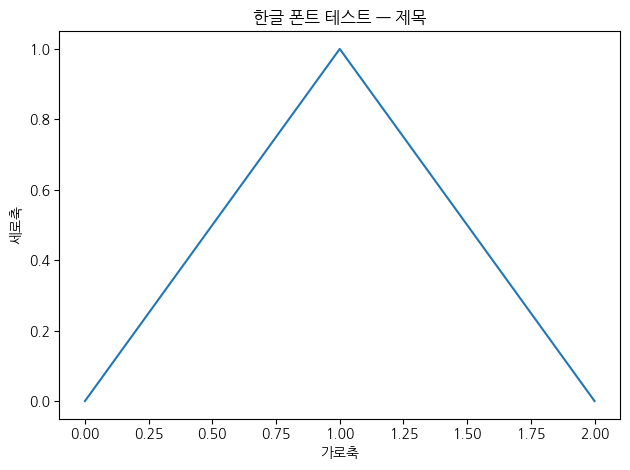

In [4]:
# ===== 한글 폰트 자동 설정 + 밝은 파랑 테마 =====
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

# 1) 밝은 테마(화이트 배경) 고정
plt.style.use('default')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor']   = 'white'
rcParams['savefig.facecolor']= 'white'
rcParams['axes.unicode_minus'] = False  # 한글 폰트와 마이너스 기호 깨짐 방지

# 2) 한글 폰트 후보 목록
KOREAN_FONT_CANDIDATES = [
    'NanumGothic',          # 리눅스/윈도우/직접설치
    'Noto Sans CJK KR',     # 리눅스/맥
    'Noto Sans KR',         # 일반 Noto Sans KR
    'Apple SD Gothic Neo',  # macOS
    'Malgun Gothic',        # Windows
    'NanumGothicCoding'
]

def pick_available_korean_font():
    # 시스템에 등록된 폰트 이름 수집
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in KOREAN_FONT_CANDIDATES:
        if name in installed:
            return name
    return None

def ensure_local_font(ttf_path):
    """작업 폴더에 TTF가 있을 때 런타임에 등록"""
    if os.path.exists(ttf_path):
        try:
            fm.fontManager.addfont(ttf_path)
            # 캐시 갱신
            try:
                fm._load_fontmanager(try_read_cache=False)
            except Exception:
                pass
            return True
        except Exception as e:
            print(f"⚠️ 폰트 등록 실패: {e}")
    return False

# 3) 우선 시스템 폰트에서 찾기
font_name = pick_available_korean_font()

# 4) 시스템에 없으면 로컬 ttf 등록 시도 (경로를 본인 환경에 맞게 바꾸세요)
LOCAL_TTF = 'NanumGothic.ttf'  # 예: '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
if font_name is None and ensure_local_font(LOCAL_TTF):
    font_name = pick_available_korean_font()

# 5) 최종 설정
if font_name:
    rcParams['font.family'] = font_name
    print(f"✅ 한글 폰트 설정 완료: {font_name}")
else:
    print("⚠️ 사용 가능한 한글 폰트를 찾지 못했습니다. 영문 기본 폰트로 진행합니다.")
    print("   해결법: 시스템에 NanumGothic/Noto Sans CJK KR 등을 설치하거나,")
    print("   현재 폴더에 'NanumGothic.ttf'를 넣은 뒤 LOCAL_TTF 경로를 맞춰주세요.")

# 6) 테스트 플롯
plt.figure()
plt.title("한글 폰트 테스트 — 제목")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([0,1,2],[0,1,0])
plt.tight_layout()
plt.show()


In [5]:
# ===== 혼동행렬 시각화: 저장된 cm(np.uint32 2D) 불러와 정규화하여 표시 =====
import numpy as np
import matplotlib.pyplot as plt
import os, json

# 💡 (Jupyter/Colab 환경 전용) 고화질 출력을 위한 설정 추가
try:
    from IPython import get_ipython
    if get_ipython() is not None and 'IPKernelApp' in get_ipython().config:
        get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except:
    pass

def load_classes(tag, save_dir="artifacts_group"):
    with open(os.path.join(save_dir, f"{tag}_classes.json"), "r", encoding="utf-8") as f:
        return json.load(f)

def plot_confusion_matrix(
    cm, class_names, title="Confusion Matrix",
    normalize='row',  # 'row' | None
):
    cm = np.asarray(cm, dtype=np.float64)
    if normalize == 'row':
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_disp = cm / row_sums
        ann_fmt = "{:.2f}"
    else:
        cm_disp = cm
        ann_fmt = "{:d}"

    fig = plt.figure(figsize=(8, 6))
    im = plt.imshow(cm_disp, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.set_ylabel('비율' if normalize=='row' else '건수')

    # 값 주석(배경 대비 글자색 자동 선택)
    vmax = cm_disp.max() if cm_disp.size else 1.0
    thresh = vmax / 2.0
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            val = cm_disp[i, j]
            txt_color = "white" if val > thresh else "black"
            plt.text(j, i, ann_fmt.format(val), ha="center", va="center", color=txt_color) 

    # Note: fontprop 변수가 정의되지 않아 주석 처리함. 
    plt.xlabel('예측값', fontsize=12)
    plt.ylabel('실제값', fontsize=12)
    plt.tight_layout()
    plt.show() # 이미지를 저장하지 않고 출력만 합니다.

def visualize_saved_confusion_matrices(save_dir="artifacts_group", normalize='row'):
    for tag in ["Protruding_P", "Inflammatory_I"]:
        cm_path = os.path.join(save_dir, f"{tag}_cm.npy")
        if not os.path.exists(cm_path):
            print(f"⚠️ CM 파일 없음: {cm_path}")
            continue
        classes = load_classes(tag, save_dir)
        cm = np.load(cm_path)
        plot_confusion_matrix(cm, classes, title=f"{tag} — Confusion Matrix", normalize=normalize)

In [6]:

# ===== 1) 공통 유틸 & 데이터 로딩 =====
import os, json, random, warnings
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
warnings.filterwarnings('ignore')

SEED = 42
def set_seed(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
set_seed()

TARGET_SIZE = (288, 288)
BASE_PATH = 'skin_dataset'

CLASS_DIRS = {
    '구진_플라그': os.path.join(BASE_PATH, 'A1_구진_플라그'),
    '비듬_각질_상피성잔고리': os.path.join(BASE_PATH, 'A2_비듬_각질_상피성잔고리'),
    '태선화_과다색소침착': os.path.join(BASE_PATH, 'A3_태선화_과다색소침착'),
    '농포_여드름': os.path.join(BASE_PATH, 'A4_농포_여드름'),
    '미란_궤양': os.path.join(BASE_PATH, 'A5_미란_궤양'),
    '결절_종괴': os.path.join(BASE_PATH, 'A6_결절_종괴')
}
CLASS_NAMES = list(CLASS_DIRS.keys())
label_to_idx = {c:i for i,c in enumerate(CLASS_NAMES)}
idx_to_label = {i:c for c,i in label_to_idx.items()}

def clamp(v, lo, hi): return max(lo, min(hi, v))

def parse_polygon_bbox(poly_info, img_w, img_h):
    loc = poly_info.get("location", [])
    xs, ys = [], []
    if isinstance(loc, list) and len(loc) > 0:
        d0 = loc[0]
        if isinstance(d0, dict) and ("x" in d0 and "y" in d0):
            for p in loc: xs.append(p.get("x",0)); ys.append(p.get("y",0))
        else:
            for k,v in d0.items():
                if str(k).startswith("x"): xs.append(v)
                elif str(k).startswith("y"): ys.append(v)
    if not xs or not ys: return None
    x_min, y_min = clamp(int(np.floor(min(xs))), 0, img_w-1), clamp(int(np.floor(min(ys))), 0, img_h-1)
    x_max, y_max = clamp(int(np.ceil(max(xs))), 0, img_w-1), clamp(int(np.ceil(max(ys))), 0, img_h-1)
    if x_max <= x_min or y_max <= y_min: return None
    return (x_min, y_min, x_max, y_max)

def parse_box_bbox(box_info, img_w, img_h):
    loc = box_info.get("location", [])
    if not isinstance(loc, list) or not loc: return None
    b = loc[0] if isinstance(loc[0], dict) else {}
    x, y, w, h = int(b.get("x",0)), int(b.get("y",0)), int(b.get("width",0)), int(b.get("height",0))
    if w <= 0 or h <= 0: return None
    x_min, y_min = clamp(x,0,img_w-1), clamp(y,0,img_h-1)
    x_max, y_max = clamp(x+w,0,img_w-1), clamp(y+h,0,img_h-1)
    if x_max <= x_min or y_max <= y_min: return None
    return (x_min, y_min, x_max, y_max)

def find_image_path(dir_path, raw_filename):
    if not raw_filename: return None
    p0 = os.path.join(dir_path, raw_filename)
    if os.path.exists(p0): return p0
    for sub in ["images","imgs","image"]:
        p = os.path.join(dir_path, sub, raw_filename)
        if os.path.exists(p): return p
    return None

def load_images_and_labels(max_json_per_class=1300):
    images, hard_labels = [], []
    bbox_fallback = 0
    for cname, cdir in CLASS_DIRS.items():
        if not os.path.isdir(cdir): 
            print("⚠️ Missing:", cdir); 
            continue
        json_files = [f for f in os.listdir(cdir) if f.lower().endswith('.json')]
        random.shuffle(json_files)
        json_files = json_files[:max_json_per_class]
        for fn in tqdm(json_files, desc=f"Loading {cname}"):
            try:
                with open(os.path.join(cdir, fn), 'r', encoding='utf-8') as f:
                    data = json.load(f)
                raw_image = data.get("metaData",{}).get("Raw data ID")
                image_path = find_image_path(cdir, raw_image)
                if not image_path: continue
                img = Image.open(image_path).convert('RGB')
                W,H = img.size

                labeling = data.get("labelingInfo",[])
                bbox = None
                for e in labeling:
                    if "polygon" in e:
                        bbox = parse_polygon_bbox(e["polygon"], W, H)
                    if bbox is None and "box" in e:
                        bbox = parse_box_bbox(e["box"], W, H)
                    if bbox is not None: break

                if bbox is not None:
                    x1,y1,x2,y2 = bbox
                    img_c = img.crop((x1,y1,x2,y2)).resize(TARGET_SIZE)
                else:
                    bbox_fallback += 1
                    img_c = img.resize(TARGET_SIZE)

                arr = img_to_array(img_c)
                images.append(arr)
                hard_labels.append(label_to_idx[cname])
            except Exception as e:
                print("error:", fn, e)
    X = np.array(images, dtype='float32')
    X = preprocess_input(X)
    y = np.array(hard_labels, dtype='int64')  # 단일 라벨 인덱스
    print(f"✅ loaded: {len(X)} | bbox fallback: {bbox_fallback}")
    return X, y

# X, y = load_images_and_labels(max_json_per_class=300)
# X_train, X_val, y_train_idx, y_val_idx = train_test_split(
#     X, y, test_size=0.3, random_state=SEED, stratify=y
# )
# print(X_train.shape, X_val.shape)


2025-11-18 19:44:30.875759: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 19:44:34.411582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 19:44:35.992887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763462676.760988   21818 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763462677.325756   21818 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763462680.183138   21818 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [7]:
# ===== 서브셋 로더: allowed_classes만 로딩 =====
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np, random, json, os
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True  # 손상된 JPEG 경고 무시하고 로드

def load_subset_images(allowed_classes, max_json_per_class=1300):
    images, labels = [], []
    bbox_fallback = 0

    for cname in allowed_classes:
        cdir = CLASS_DIRS[cname]
        if not os.path.isdir(cdir):
            print("⚠️ Missing:", cdir); 
            continue

        json_files = [f for f in os.listdir(cdir) if f.lower().endswith('.json')]
        random.shuffle(json_files)
        json_files = json_files[:max_json_per_class]

        for fn in tqdm(json_files, desc=f"Loading {cname}"):
            try:
                with open(os.path.join(cdir, fn), 'r', encoding='utf-8') as f:
                    data = json.load(f)

                raw_image = data.get("metaData",{}).get("Raw data ID")
                image_path = find_image_path(cdir, raw_image)
                if not image_path: 
                    continue

                img = Image.open(image_path).convert('RGB')
                W, H = img.size

                # BBox 우선, 없으면 풀 이미지
                labeling = data.get("labelingInfo",[])
                bbox = None
                for e in labeling:
                    if "polygon" in e:
                        bbox = parse_polygon_bbox(e["polygon"], W, H)
                    if bbox is None and "box" in e:
                        bbox = parse_box_bbox(e["box"], W, H)
                    if bbox is not None:
                        break

                if bbox is not None:
                    x1,y1,x2,y2 = bbox
                    img_c = img.crop((x1,y1,x2,y2)).resize(TARGET_SIZE)
                else:
                    bbox_fallback += 1
                    img_c = img.resize(TARGET_SIZE)

                arr = img_to_array(img_c)
                images.append(arr)
                labels.append(cname)

            except Exception as e:
                print("error:", fn, e)

    X = np.array(images, dtype='float32')
    X = preprocess_input(X)

    # 서브셋 전용 라벨 인덱스
    uniq = list(dict.fromkeys(allowed_classes))  # 순서 보장
    sub_label_to_idx = {c:i for i,c in enumerate(uniq)}
    y = np.array([sub_label_to_idx[c] for c in labels], dtype='int64')

    print(f"✅ loaded: {len(X)} | bbox fallback: {bbox_fallback} | classes={uniq}")
    return X, y, sub_label_to_idx


In [8]:
# ===== MobileNetV2 + 3-way softmax, 학습/평가 유틸 =====
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np, os, json
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D


# 추가 ⬇️
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input,
    Dense, Dropout, BatchNormalization,
    Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate  # 🔹 여기까지
)
import tensorflow as tf

import gc

def build_multiclass_model(
    num_classes: int,
    input_shape=(288, 288, 3),
    head_units: int = 128,
    dropout: float = 0.6,
    wd: float = 1e-4,
    label_smoothing: float = 0.0
):
    inp = Input(shape=input_shape, name="input_image")
    base = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
        name="backbone",
    )

    base.trainable = False

    x = base(inp)
    x = Conv2D(64, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    gap = GlobalAveragePooling2D()(x)
    gmp = GlobalMaxPooling2D()(x)
    x = Concatenate(axis=-1)([gap, gmp])
    x = Dense(
        head_units,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(wd),
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    out = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inp, out, name=f"mobilenetv2_{num_classes}cls")

    if label_smoothing and label_smoothing > 0:
        try:
            loss = tf.keras.losses.SparseCategoricalCrossentropy(
                label_smoothing=label_smoothing
            )
        except TypeError:
            def sparse_ce_with_smoothing(y_true, y_pred):
                y_true = tf.cast(y_true, tf.int32)
                y_true_oh = tf.one_hot(y_true, depth=num_classes)
                y_true_ls = (
                    y_true_oh * (1.0 - label_smoothing)
                    + (label_smoothing / num_classes)
                )
                return tf.keras.losses.categorical_crossentropy(
                    y_true_ls, y_pred
                )
            loss = sparse_ce_with_smoothing
    else:
        loss = tf.keras.losses.SparseCategoricalCrossentropy()

    opt = tf.keras.optimizers.AdamW(
        learning_rate=3e-4,
        weight_decay=1e-4,
        clipnorm=1.0,
    )
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model


def unfreeze_last_blocks(model, n_layers_to_unfreeze=50, lr=1e-5):
    """
    상위 모델 안에 들어있는 서브모델 'backbone'의 마지막 N개 레이어를 언프리즈.
    """
    try:
        base = model.get_layer('backbone')  # ← 위 build에서 이름 지정
    except ValueError:
        # 디버그 도움: 현재 최상위 레이어 이름들 출력
        print("현재 모델 최상위 레이어들:", [L.name for L in model.layers[:10]], "...")
        raise RuntimeError("백본('backbone') 레이어를 찾지 못했습니다. build_multiclass_model에서 name='backbone'을 지정하고, base(inp) 형태로 호출했는지 확인하세요.")

    total = len(base.layers)
    if n_layers_to_unfreeze <= 0:
        print("⚠️ unfreeze 레이어 수가 0 이하입니다. 스킵합니다.")
        return model
    if n_layers_to_unfreeze > total:
        print(f"ℹ️ 요청한 수({n_layers_to_unfreeze})가 백본 총 레이어({total})보다 큽니다. 전체 언프리즈로 진행합니다.")
        n_layers_to_unfreeze = total

    base.trainable = False
    # 앞부분 freeze, 마지막 N개만 trainable
    for layer in base.layers[:-n_layers_to_unfreeze]:
        layer.trainable = False
    for layer in base.layers[-n_layers_to_unfreeze:]:
        layer.trainable = True

    print(f"✅ backbone 레이어 총 {total}개 중 마지막 {n_layers_to_unfreeze}개 언프리즈")
    print("   마지막 5개 레이어:", [l.name for l in base.layers[-5:]])

    # 작은 LR로 재컴파일
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-5, clipnorm=1.0),
        loss=model.loss,
        metrics=['accuracy']
    )
    return model


def train_eval_save(
    X, y, class_names, tag: str, save_dir="artifacts_group",
    batch_size=16, epochs=8
):
    # freeze 학습만 진행 + 학습 후 자동으로 혼동행렬 시각화 출력
    os.makedirs(save_dir, exist_ok=True)

    # ---- 사전 로그 ----
    X = np.asarray(X); y = np.asarray(y)

    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.3, random_state=SEED, stratify=y
    )

    # class_weight 계산
    uniq = np.unique(y_tr)
    cw = compute_class_weight(class_weight='balanced', classes=uniq, y=y_tr)
    class_weight = {int(c): float(w) for c, w in zip(uniq, cw)}
    print("[class_weight]", class_weight)

    print(f"[Split] X_tr:{X_tr.shape}, X_val:{X_val.shape}")

    # 증강
    gen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # 모델 생성
    model = build_multiclass_model(
        num_classes=len(class_names),
        input_shape=(288,288,3),
        label_smoothing=0.05
    )

    ckpt = os.path.join(save_dir, f"{tag}_best.h5")
    cbs = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
        ModelCheckpoint(ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
    ]

    print(f"\n🚀 [단일 단계 학습 시작] — {tag}")
    model.fit(
        gen.flow(X_tr, y_tr, batch_size=batch_size, shuffle=True),
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=cbs,
        verbose=1,
        class_weight=class_weight
    )

    # ===== 평가 =====
    print("\n🧪 검증셋 예측 중...")
    y_val_prob = model.predict(X_val, verbose=0)
    y_val_hat = np.argmax(y_val_prob, axis=1)

    print("\n=== Classification Report ===")
    print(classification_report(y_val, y_val_hat, target_names=class_names, digits=4))

    cm = confusion_matrix(y_val, y_val_hat)
    print("Confusion Matrix:\n", cm)

    # 저장
    final_path = os.path.join(save_dir, f"{tag}_final.h5")
    model.save(final_path)

    with open(os.path.join(save_dir, f"{tag}_classes.json"), "w", encoding="utf-8") as f:
        json.dump(class_names, f, ensure_ascii=False, indent=2)

    np.save(os.path.join(save_dir, f"{tag}_cm.npy"), cm)

    print(f"\n💾 Saved: {final_path}")
    print(f"💾 Best ckpt saved at: {ckpt}")

    # ===== 🔥 혼동행렬 바로 시각화 — 여기 추가됨 =====
    print(f"\n📊 [{tag}] Confusion Matrix Visualization")
    plot_confusion_matrix(
        cm,
        class_names,
        title=f"{tag} — Confusion Matrix",
        normalize='row'
    )

    # 메모리 정리
    gc.collect()
    try:
        tf.keras.backend.clear_session()
    except:
        pass

    return model, (X_val, y_val, y_val_prob)


Loading 결절_종괴: 100%|██████████| 1500/1500 [01:19<00:00, 18.86it/s]


✅ loaded: 4321 | bbox fallback: 0 | classes=['구진_플라그', '태선화_과다색소침착', '결절_종괴']
[class_weight] {0: 0.9609151572926596, 1: 0.96, 2: 1.0897297297297297}
[Split] X_tr:(3024, 288, 288, 3), X_val:(1297, 288, 288, 3)


2025-11-18 19:49:25.495284: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-11-18 19:49:25.503533: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-18 19:49:25.503568: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: jupyter02
2025-11-18 19:49:25.504054: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: jupyter02
2025-11-18 19:49:25.511287: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.54.14
2025-11-18 19:49:25.533662: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 550.54.14
2


🚀 [단일 단계 학습 시작] — Protruding_P
Epoch 1/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.4206 - loss: 1.6578
Epoch 1: val_accuracy improved from -inf to 0.55281, saving model to artifacts_group/Protruding_P_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4208 - loss: 1.6570 - val_accuracy: 0.5528 - val_loss: 1.2512 - learning_rate: 3.0000e-04
Epoch 2/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.5331 - loss: 1.2140
Epoch 2: val_accuracy did not improve from 0.55281
189/189 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5331 - loss: 1.2141 - val_accuracy: 0.5359 - val_loss: 1.2582 - learning_rate: 3.0000e-04
Epoch 3/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.5796 - loss: 1.1262
Epoch 3: val_accuracy improved from 0.55281 to 0.62760, saving model to artifacts_group/Protruding_P_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5796 - loss: 1.1263 - val_accuracy: 0.6276 - val_loss: 1.0384 - learning_rate: 3.0000e-04
Epoch 4/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.5742 - loss: 1.0784
Epoch 4: val_accuracy did not improve from 0.62760
189/189 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.5743 - loss: 1.0783 - val_accuracy: 0.6253 - val_loss: 0.9125 - learning_rate: 3.0000e-04
Epoch 5/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.5980 - loss: 1.0187
Epoch 5: val_accuracy improved from 0.62760 to 0.63069, saving model to artifacts_group/Protruding_P_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5980 - loss: 1.0187 - val_accuracy: 0.6307 - val_loss: 0.9755 - learning_rate: 3.0000e-04
Epoch 6/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.6316 - loss: 0.9361
Epoch 6: val_accuracy improved from 0.63069 to 0.65073, saving model to artifacts_group/Protruding_P_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.6316 - loss: 0.9360 - val_accuracy: 0.6507 - val_loss: 0.9736 - learning_rate: 3.0000e-04
Epoch 7/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.6827 - loss: 0.8375
Epoch 7: val_accuracy improved from 0.65073 to 0.66769, saving model to artifacts_group/Protruding_P_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.6827 - loss: 0.8375 - val_accuracy: 0.6677 - val_loss: 0.8796 - learning_rate: 9.0000e-05
Epoch 8/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.6917 - loss: 0.7847
Epoch 8: val_accuracy improved from 0.66769 to 0.69468, saving model to artifacts_group/Protruding_P_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.6918 - loss: 0.7846 - val_accuracy: 0.6947 - val_loss: 0.8603 - learning_rate: 9.0000e-05

🧪 검증셋 예측 중...

=== Classification Report ===


              precision    recall  f1-score   support

      구진_플라그     0.7290    0.6933    0.7107       450
  태선화_과다색소침착     0.6845    0.6267    0.6543       450
       결절_종괴     0.6718    0.7733    0.7190       397

    accuracy                         0.6947      1297
   macro avg     0.6951    0.6978    0.6947      1297
weighted avg     0.6960    0.6947    0.6937      1297

Confusion Matrix:
 [[312  81  57]
 [ 75 282  93]
 [ 41  49 307]]

💾 Saved: artifacts_group/Protruding_P_final.h5
💾 Best ckpt saved at: artifacts_group/Protruding_P_best.h5

📊 [Protruding_P] Confusion Matrix Visualization


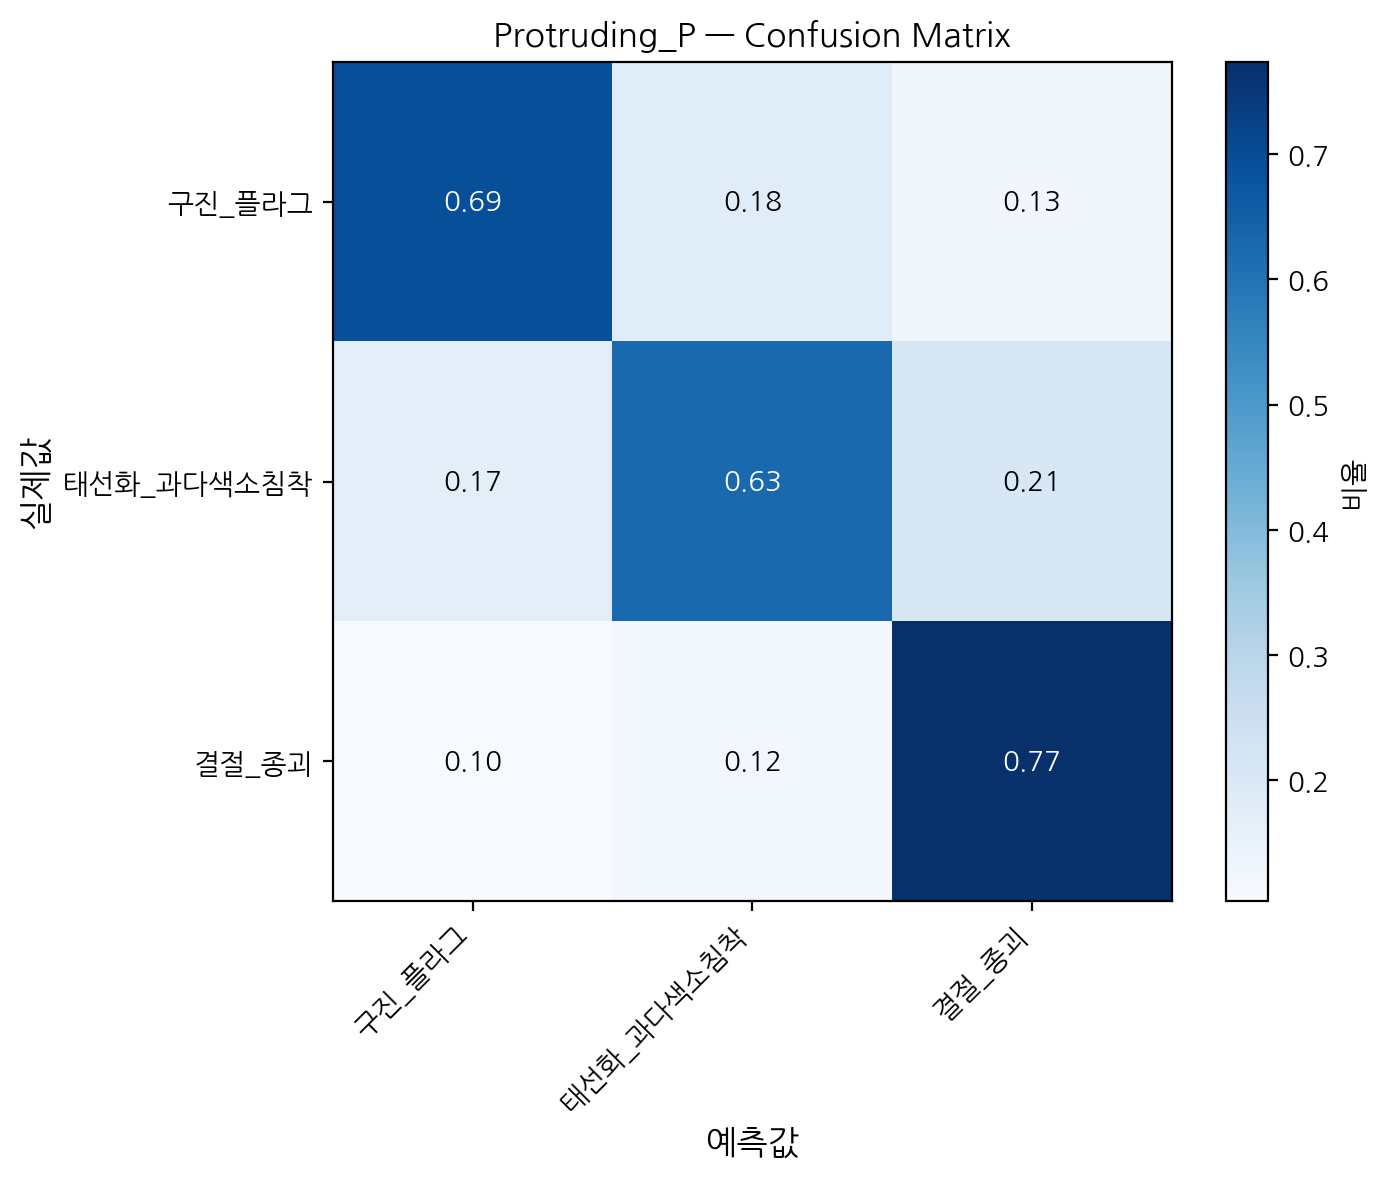

In [9]:
# ===== 모델 P: Protruding (A1, A3, A6) =====
allowed_P = ['구진_플라그', '태선화_과다색소침착', '결절_종괴']  # A1, A3, A6
X_P, y_P, map_P = load_subset_images(allowed_P, max_json_per_class=1500)

# 인덱스 순서대로 클래스명 배열 구성
classes_P = [None]*len(map_P)
for name, idx in map_P.items():
    classes_P[idx] = name

model_P, valpack_P = train_eval_save(X_P, y_P, classes_P, tag="Protruding_P", save_dir="artifacts_group")


Loading 결절_종괴: 100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


✅ loaded: 2369 | bbox fallback: 0 | classes=['농포_여드름', '미란_궤양', '결절_종괴']
[class_weight] {0: 0.7998070429329475, 1: 1.579047619047619, 2: 0.8957320367368989}
[Split] X_tr:(1658, 288, 288, 3), X_val:(711, 288, 288, 3)

🚀 [단일 단계 학습 시작] — Inflammatory_I
Epoch 1/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.4346 - loss: 1.6563
Epoch 1: val_accuracy improved from -inf to 0.61744, saving model to artifacts_group/Inflammatory_I_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.4351 - loss: 1.6554 - val_accuracy: 0.6174 - val_loss: 1.3965 - learning_rate: 3.0000e-04
Epoch 2/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.5712 - loss: 1.3279
Epoch 2: val_accuracy improved from 0.61744 to 0.62447, saving model to artifacts_group/Inflammatory_I_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5712 - loss: 1.3278 - val_accuracy: 0.6245 - val_loss: 1.0482 - learning_rate: 3.0000e-04
Epoch 3/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.6071 - loss: 1.2033
Epoch 3: val_accuracy did not improve from 0.62447
104/104 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6070 - loss: 1.2034 - val_accuracy: 0.5767 - val_loss: 1.2725 - learning_rate: 3.0000e-04
Epoch 4/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.5947 - loss: 1.1486
Epoch 4: val_accuracy did not improve from 0.62447
104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5948 - loss: 1.1481 - val_accuracy: 0.5401 - val_loss: 1.4250 - learning_rate: 3.0000e-04
Epoch 5/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.6324 - loss: 1.0007
Epoch 5: val_accuracy improved from 0.62447 to 0.65401, saving model to artifacts_group/Inflammatory_I_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6325 - loss: 1.0006 - val_accuracy: 0.6540 - val_loss: 0.9347 - learning_rate: 9.0000e-05
Epoch 6/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.6583 - loss: 0.9528
Epoch 6: val_accuracy did not improve from 0.65401
104/104 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6584 - loss: 0.9527 - val_accuracy: 0.6512 - val_loss: 0.9510 - learning_rate: 9.0000e-05
Epoch 7/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.6928 - loss: 0.8904
Epoch 7: val_accuracy did not improve from 0.65401
104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6929 - loss: 0.8903 - val_accuracy: 0.6470 - val_loss: 0.9747 - learning_rate: 9.0000e-05
Epoch 8/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.6809 - loss: 0.8949
Epoch 8: val_accuracy improved from 0.65401 to 0.67229, saving model to artifacts_group/Inflammatory_I_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6811 - loss: 0.8950 - val_accuracy: 0.6723 - val_loss: 0.9309 - learning_rate: 2.7000e-05

🧪 검증셋 예측 중...

=== Classification Report ===


              precision    recall  f1-score   support

      농포_여드름     0.7239    0.6554    0.6879       296
       미란_궤양     0.5155    0.6667    0.5814       150
       결절_종괴     0.7390    0.6943    0.7160       265

    accuracy                         0.6723       711
   macro avg     0.6594    0.6721    0.6618       711
weighted avg     0.6855    0.6723    0.6759       711

Confusion Matrix:
 [[194  51  51]
 [ 36 100  14]
 [ 38  43 184]]

💾 Saved: artifacts_group/Inflammatory_I_final.h5
💾 Best ckpt saved at: artifacts_group/Inflammatory_I_best.h5

📊 [Inflammatory_I] Confusion Matrix Visualization


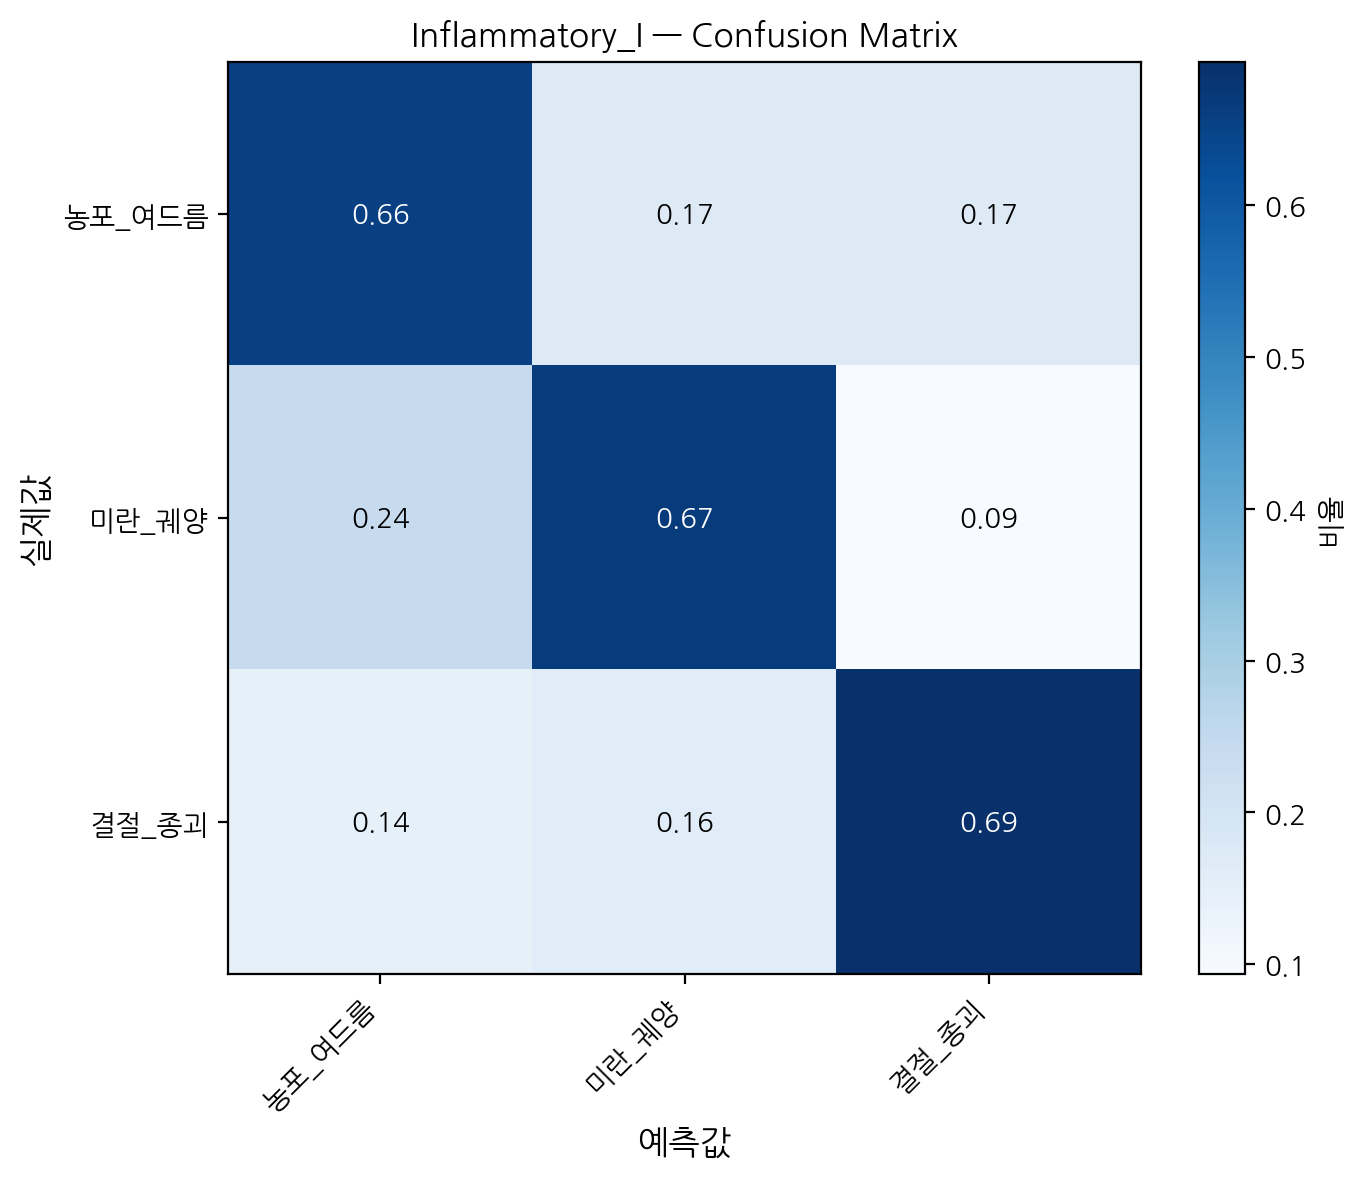

In [10]:
# ===== 모델 I: Inflammatory (A4, A5, A6) =====
allowed_I = ['농포_여드름', '미란_궤양', '결절_종괴']          # A4, A5, A6
X_I, y_I, map_I = load_subset_images(allowed_I, max_json_per_class=1000)

classes_I = [None]*len(map_I)
for name, idx in map_I.items():
    classes_I[idx] = name

model_I, valpack_I = train_eval_save(X_I, y_I, classes_I, tag="Inflammatory_I", save_dir="artifacts_group")


✅ 혼동행렬 시각화 준비 — visualize_saved_confusion_matrices()


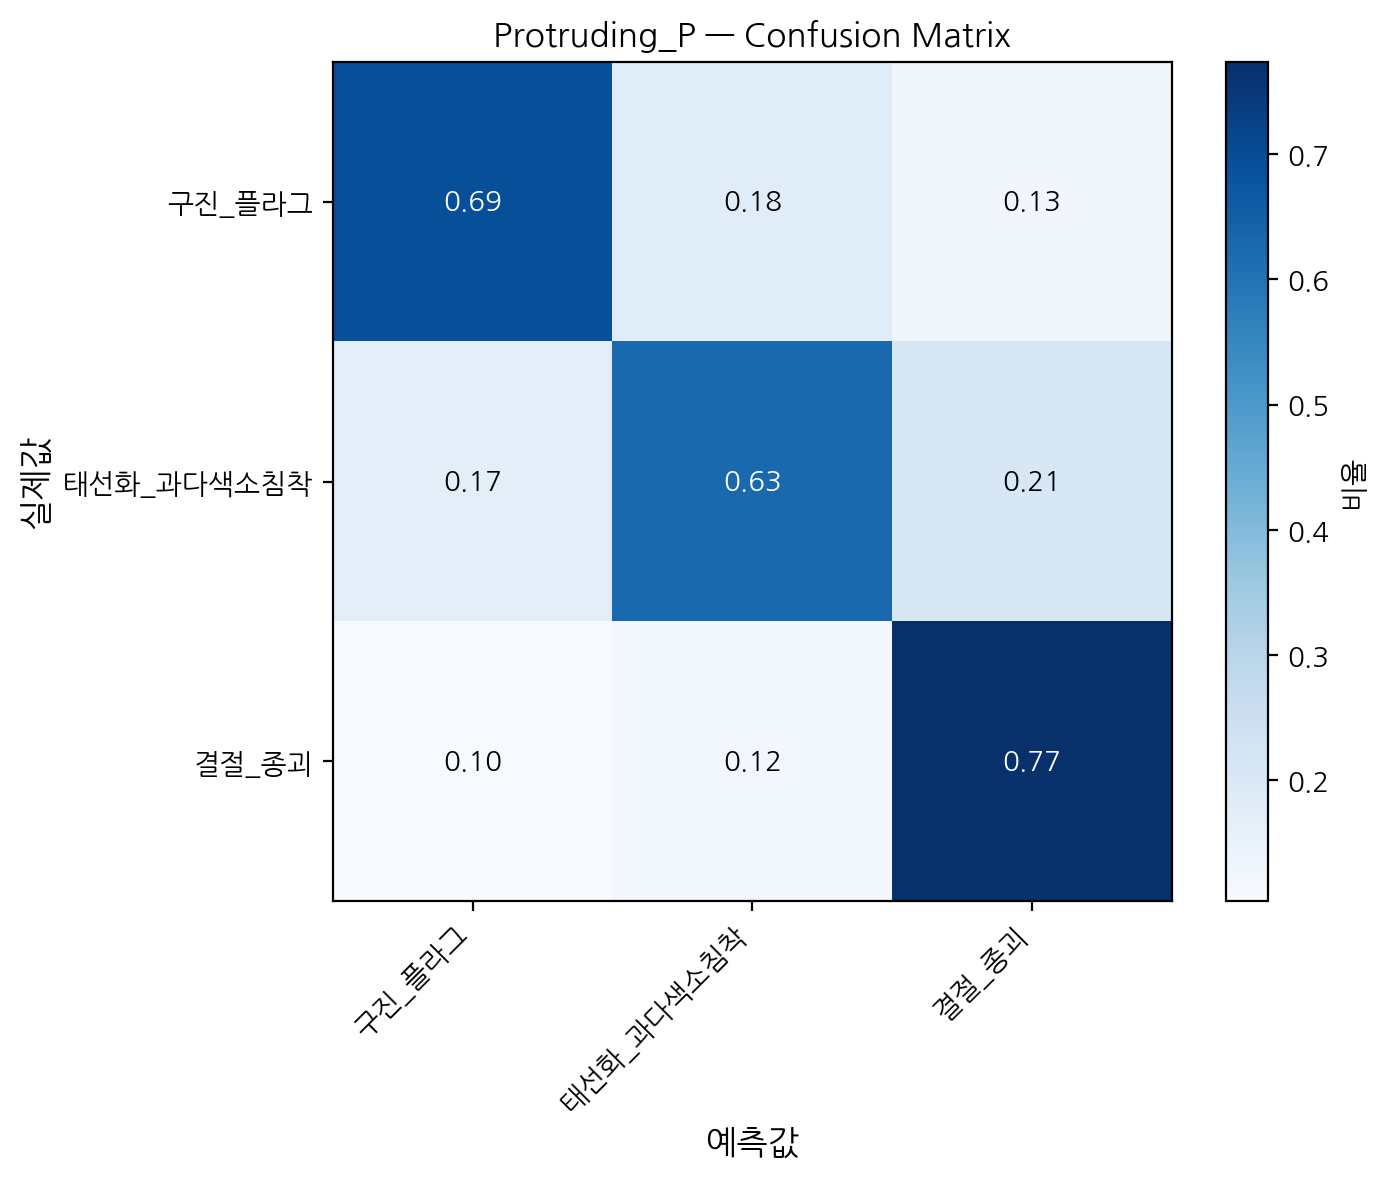

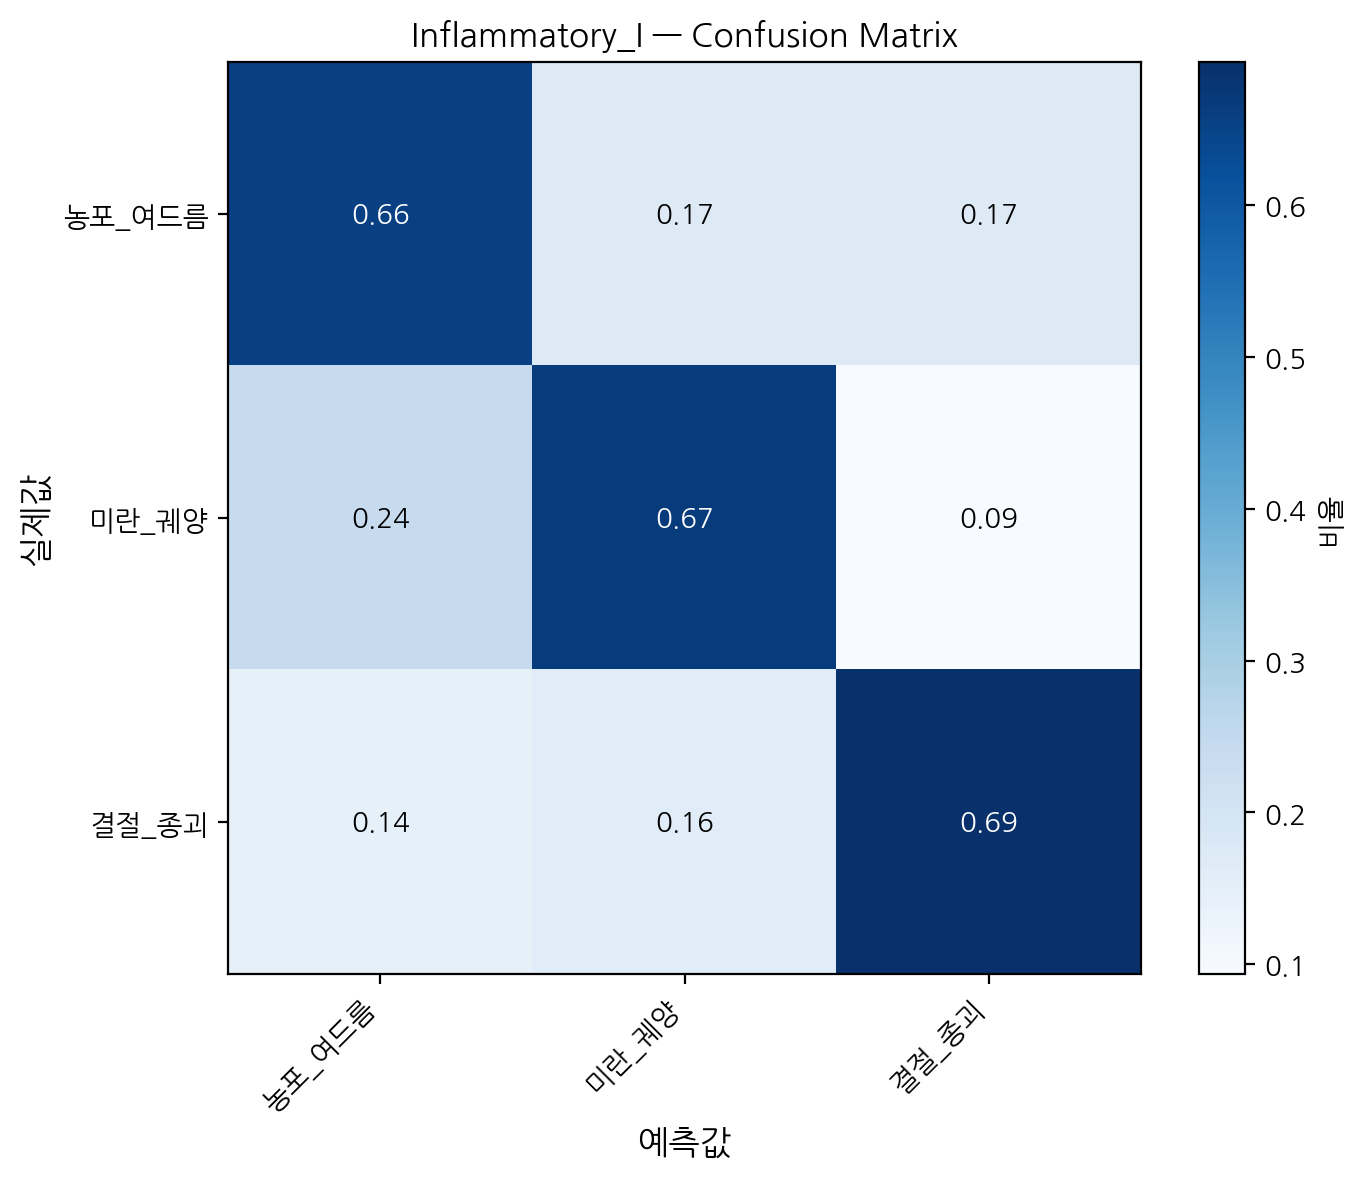

In [14]:
def infer_folder_multi(image_dir, tags, base_dir="artifacts_group"):
    """
    여러 모델(tag 리스트)에 대해 폴더 안의 모든 이미지에 대해 한 번에 추론.
    """
    models = {}
    for tag in tags:
        models[tag] = load_group_model(tag, base_dir)

    exts = (".jpg", ".jpeg", ".png")
    files = [f for f in os.listdir(image_dir) if f.lower().endswith(exts)]
    files.sort()

    results = []

    for fname in files:
        path = os.path.join(image_dir, fname)
        img_arr, _ = preprocess_image_for_infer(path)

        per_image_result = {"file": fname}

        for tag in tags:
            model, class_names = models[tag]
            prob = model.predict(img_arr, verbose=0)[0]
            pred_idx = int(np.argmax(prob))
            pred_cls = class_names[pred_idx]

            per_image_result[tag] = {
                "pred": pred_cls,
                "prob": float(prob[pred_idx])
            }

        results.append(per_image_result)

    # 결과 출력
    for r in results:
        print("\n📌", r["file"])
        for tag in tags:
            print(f" - {tag}: {r[tag]['pred']} ({r[tag]['prob']:.4f})")

    return results


In [1]:
# ====== 폴더 기반 일괄 테스트 (Model P & Model I, 코드 → 라벨 규칙 반영) ======
import os, json
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 0. 테스트 루트 폴더
# -----------------------------
TEST_ROOT = "피부테스트"   # 필요하면 경로 수정

IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp")

# -----------------------------
# 1. 실제 라벨 규칙 (설명용)
# -----------------------------
code_to_label_full = {
    "A1": "구진·플라그",
    "A2": "비듬·각질·상피성잔고리",
    "A3": "태선화·과다색소침착",
    "A4": "농포·여드름",
    "A5": "미란·궤양",
    "A6": "결절·종괴",
}

# -----------------------------
# 2. 모델별 "내부 클래스명" 매핑
#    (artifacts_group/..._classes.json 에 들어있는 이름과 맞아야 함)
# -----------------------------
# Model P : A1, A3, A6 만
code_to_label_P = {
    "A1": "구진_플라그",
    "A3": "태선화_과다색소침착",
    "A6": "결절_종괴",
}

# Model I : A4, A5, A6 만
code_to_label_I = {
    "A4": "농포_여드름",
    "A5": "미란_궤양",
    "A6": "결절_종괴",
}

# -----------------------------
# 3. 모델 로더 (_best.h5 사용)
# -----------------------------
def load_group_model(tag, base_dir="artifacts_group"):
    model_path   = os.path.join(base_dir, f"{tag}_best.h5")
    classes_path = os.path.join(base_dir, f"{tag}_classes.json")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"모델 파일 없음: {model_path}")
    if not os.path.exists(classes_path):
        raise FileNotFoundError(f"클래스 파일 없음: {classes_path}")

    model = load_model(model_path, compile=False)
    with open(classes_path, "r", encoding="utf-8") as f:
        class_names = json.load(f)

    print(f"✅ Loaded model: {model_path}")
    print(f"✅ Loaded classes: {class_names}")
    return model, class_names

# -----------------------------
# 4. 이미지 전처리 (288x288 + MobileNetV2 preprocess)
# -----------------------------
def preprocess_image(path, target_size=(288, 288)):
    img = Image.open(path).convert("RGB")
    img = img.resize(target_size)
    arr = np.array(img, dtype="float32")
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    return arr

# -----------------------------
# 5. 파일명에서 A코드 추출
#    예: "IMG_D_A6_496339.jpg" → "A6"
# -----------------------------
def extract_code_from_filename(filename):
    filename_up = filename.upper()
    for code in ["A1", "A2", "A3", "A4", "A5", "A6"]:
        if code in filename_up:
            return code
    return None

# -----------------------------
# 6. 공통 평가 함수
# -----------------------------
def evaluate_group_model(model,
                         class_names,
                         test_root,
                         allow_codes,
                         code_to_internal_label,
                         code_to_label_full):

    y_true = []
    y_pred = []

    print(f"\n📂 테스트 루트 폴더: {os.path.abspath(test_root)}")
    print(f"허용 코드: {allow_codes}")

    for root, dirs, files in os.walk(test_root):
        for fname in files:
            if not fname.lower().endswith(IMG_EXT):
                continue

            code = extract_code_from_filename(fname)
            if code is None or code not in allow_codes:
                continue

            # 내부용 클래스 이름 (모델의 class_names 와 일치해야 함)
            internal_name = code_to_internal_label.get(code)
            if internal_name not in class_names:
                print(f"⚠️ {fname}: 코드 {code} → 내부라벨 '{internal_name}' 가 class_names에 없음, 스킵")
                continue

            true_idx = class_names.index(internal_name)
            true_desc = code_to_label_full.get(code, internal_name)

            fpath = os.path.join(root, fname)

            # 예측
            x = preprocess_image(fpath)
            probs = model.predict(x, verbose=0)[0]   # (num_classes,)
            pred_idx = int(np.argmax(probs))
            pred_label = class_names[pred_idx]

            y_true.append(true_idx)
            y_pred.append(pred_idx)

            prob_str = ", ".join(
                f"{cls}={p:.3f}" for cls, p in zip(class_names, probs)
            )
            correct = "✅" if pred_idx == true_idx else "❌"

            print(
                f"{correct} {fname} | 코드:{code} | GT:{internal_name} ({true_desc}) "
                f"| Pred:{pred_label} | [{prob_str}]"
            )

    if not y_true:
        print("\n⚠️ 평가에 사용된 이미지가 없습니다. (코드/경로 확인 필요)")
        return

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n📊 Classification Report (index 기준)")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

# -----------------------------
# 7. 실제 실행: Model P / Model I
# -----------------------------

print("========================")
print("     🔵 Model P 테스트")
print("========================")
model_P, classes_P = load_group_model("Protruding_P")
evaluate_group_model(
    model_P,
    classes_P,
    TEST_ROOT,
    allow_codes=["A1", "A3", "A6"],
    code_to_internal_label=code_to_label_P,
    code_to_label_full=code_to_label_full,
)

print("\n========================")
print("     🔴 Model I 테스트")
print("========================")
model_I, classes_I = load_group_model("Inflammatory_I")
evaluate_group_model(
    model_I,
    classes_I,
    TEST_ROOT,
    allow_codes=["A4", "A5", "A6"],
    code_to_internal_label=code_to_label_I,
    code_to_label_full=code_to_label_full,
)


2025-11-23 09:56:18.013262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 09:56:21.622067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 09:56:23.324719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763859384.354232   30674 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763859384.916410   30674 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763859387.967962   30674 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

     🔵 Model P 테스트


2025-11-23 09:57:14.367636: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-11-23 09:57:14.378496: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-23 09:57:14.378524: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: jupyter01
2025-11-23 09:57:14.378931: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: jupyter01
2025-11-23 09:57:14.386817: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.54.14
2025-11-23 09:57:14.386912: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 550.54.14
2

✅ Loaded model: artifacts_group/Protruding_P_best.h5
✅ Loaded classes: ['구진_플라그', '태선화_과다색소침착', '결절_종괴']

📂 테스트 루트 폴더: /scratch/e1430a18/workspace/피부테스트
허용 코드: ['A1', 'A3', 'A6']
✅ IMG_D_A3_170957.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:태선화_과다색소침착 | [구진_플라그=0.023, 태선화_과다색소침착=0.861, 결절_종괴=0.115]
✅ IMG_D_A3_170964.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:태선화_과다색소침착 | [구진_플라그=0.007, 태선화_과다색소침착=0.988, 결절_종괴=0.005]
✅ IMG_D_A3_170971.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:태선화_과다색소침착 | [구진_플라그=0.007, 태선화_과다색소침착=0.805, 결절_종괴=0.187]
❌ IMG_D_A3_170940.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:결절_종괴 | [구진_플라그=0.016, 태선화_과다색소침착=0.198, 결절_종괴=0.786]
❌ IMG_D_A3_170949.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:결절_종괴 | [구진_플라그=0.123, 태선화_과다색소침착=0.424, 결절_종괴=0.452]
✅ IMG_D_A3_170950.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:태선화_과다색소침착 | [구진_플라그=0.109, 태선화_과다색소침착=0.459, 결절_종괴=0.432]
❌ IMG_D_A3_170920.jpg | 코드:A3 | GT:태선화_과다색소침착 (태선화·과다색소침착) | Pred:구진_플라그 | [구진_플라